In [1]:
# -*- coding: utf-8 -*-
"""
Training an image classifier
----------------------------
We will do the following steps in order:
1. Load and normalizing the MNIST training and test datasets using
   ``torchvision``
2. Define a SVM model
3. Define a loss function
4. Train the model on the training data
5. Test the model on the test data
1. Loading and normalizing MNIST
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Using ``torchvision``, it’s extremely easy to load MNIST.
"""
import torch
import torchvision
import torchvision.transforms as transforms
import itertools

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
# .. note::
#     If running on Windows and you get a BrokenPipeError, try setting
#     the num_worker of torch.utils.data.DataLoader() to 0.

In [2]:
pytorch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


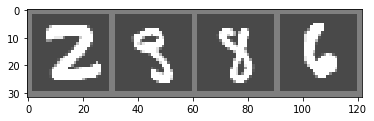

    2     3     8     6


In [4]:
########################################################################
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# get some random training images
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

# show images
imshow(torchvision.utils.make_grid(example_data[:4]))


# print labels
print(' '.join('%5s' % classes[example_targets[j]] for j in range(4)))

In [7]:
########################################################################
# 2. Define a SVM model
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.svm_layer = nn.Linear(784, 10) ### YOUR CODE ###, ### YOUR CODE ###
        
    def forward(self, x):
        # shape of input (=x): [16, 1, 28, 28]
        # shape of output: [16, 10]
        x = x.view(-1, 1 * 28 * 28)
        prediction = self.svm_layer(x) ### YOUR CODE ####
        return prediction
                                
model = Model().to(pytorch_device)

In [12]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss().to(pytorch_device) ### YOUR CODE ###
optimizer = optim.SGD(model.parameters(), lr=0.1 ) ### YOUR CODE ###

In [ ]:
########################################################################
# 4. Train the model
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# model and optimize.

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(pytorch_device), labels.to(pytorch_device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels) ### YOUR CODE ###
        loss.backward() ### YOUR CODE ###
        optimizer.step() ### YOUR CODE ###

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
########################################################################
# See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
# for more details on saving PyTorch models.
#
# 5. Test the model on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the model for 2 passes over the training dataset.
# But we need to check if the model has learnt anything at all.
#
# We will check this by predicting the class label that the model
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(pytorch_device), labels.to(pytorch_device)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

########################################################################
# Okay, now let us see what the model thinks these examples above are:

outputs = model(images)

########################################################################
# The outputs are energies for the 10 classes.
# The higher the energy for a class, the more the model
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

########################################################################
# The results seem pretty good.
#
# Let us look at how the model performs on the whole dataset.

correct = 0
total = 0

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on the 60000 train images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
cmt = torch.zeros(10,10, dtype=torch.int64)


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            cmt[labels[i], predicted[i]] += 1
            class_correct[label] += c[i].item()
            class_total[label] += 1


print('Accuracy of the model on the 10000 test images: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cmt.numpy(), classes)

NameError: name 'cmt' is not defined

<Figure size 720x720 with 0 Axes>